# RynnEC Inference Recipes

## Section 2: Spatial Understanding
In this section, we introduce the most effective approaches for achieving spatial understanding using RynnEC. This involves leveraging the ability of Multimodal Large Language Models (MLLMs) to process egocentric videos, thereby facilitating the development of 3D spatial awareness.

### [General] Load Model and Processor
Loading the 2B model requires approximately 4,750 MB of VRAM at BFloat16 precision. To ensure that only one GPU is used, we restrict the CUDA visible devices to GPU 0 in this example code.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import copy
import math
import warnings
import shutil
from functools import partial
from decord import VideoReader, cpu
from matplotlib import pyplot as plt
import torch
import numpy as np
from rynnec.model import load_pretrained_model
from rynnec.mm_utils import load_images, process_images, load_video, process_video, tokenizer_multimodal_token, get_model_name_from_path, KeywordsStoppingCriteria, DirectResize, sam_preprocess_batch
from rynnec.constants import NUM_FRAMES, DEFAULT_IMAGE_TOKEN, DEFAULT_VIDEO_TOKEN, MODAL_INDEX_MAP, STREAM_START_TOKEN, STREAM_END_TOKEN
from rynnec.model.rynnec_qwen2 import Videollama3Qwen2Processor
from rynnec import disable_torch_init, model_init, mm_infer
import warnings
from PIL import Image
warnings.filterwarnings("ignore")

model_path = "Alibaba-DAMO-Academy/RynnEC-2B"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)

if tokenizer.pad_token is None and tokenizer.unk_token is not None:
    tokenizer.pad_token = tokenizer.unk_token

processor = Videollama3Qwen2Processor(image_processor, tokenizer)

/usr/local/conda/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:520: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Some weights of the model checkpoint at /mnt/damovl/scene_understanding/code/vl3-scene-sft-sam2/checkpoints/RynnEC-2B were not used when initializing RynnecQwen2ForCausalLM: ['grounding_encoder.sam2_model.memory_encoder.fuser.layers.0.weight', 'grounding_encoder.sam2_model.memory_encoder.fuser.layers.1.weight']
- This IS expected if you are initializing RynnecQwen2ForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForP

### [Case 1]: distance between objects
### 1.load the video

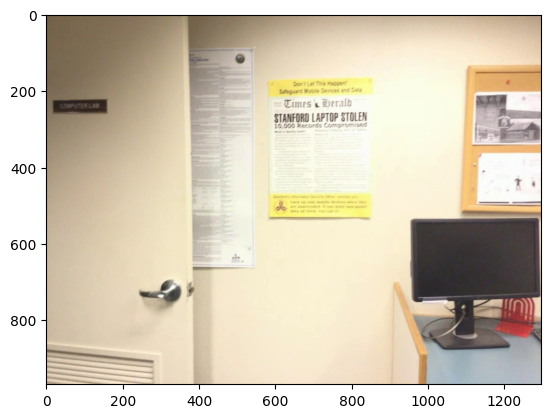

In [2]:
video_path ='../videos/0.mp4'
frames, timestamps = load_video(video_path, fps=1, max_frames=128)
frames = [Image.fromarray(x.transpose(1, 2, 0)) for x in frames]

frame_idx = 0 # choose the frame idx
plt.imshow(frames[frame_idx])

### 2.Select objects with sam2

In [3]:
from transformers import SamModel, SamProcessor
device = "cuda"
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

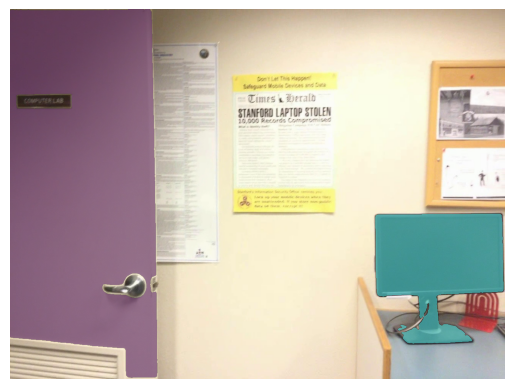

In [4]:
def get_segmentation_from_box(input_boxes, frame_data):
  inputs = sam_processor(frame_data, input_boxes=input_boxes, return_tensors="pt").to(device)
  with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    outputs = sam_model(**inputs)

  masks = sam_processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0][0]
  scores = outputs.iou_scores[0, 0]
  mask_selection_index = scores.argmax()
  mask = masks[mask_selection_index]
  return mask

frame_data = frames[frame_idx]
mask1 = get_segmentation_from_box([[[0, 0, 400, 1000]]], frame_data)
mask2 = get_segmentation_from_box([[[900, 500, 1300, 900]]], frame_data)
plt.imshow(np.array(frame_data))
ax = plt.gca()


show_mask(mask1, ax=ax, random_color=True)
show_mask(mask2, ax=ax, random_color=True)

plt.axis("off")
plt.show()

### 3.Inference with RynnEC

In [5]:
masks = [mask1, mask2]
masks = torch.from_numpy(np.array(masks))

instruction = f"<video>\nThere are two region in the video: <object0>[<REGION>], <object1>[<REGION>]. What is the distance between <object0> and <object1>?"

mask_ids = [frame_idx]*len(masks) 
output = mm_infer(
    (frames, timestamps),
    processor,
    instruction,
    model=model,
    tokenizer=processor.tokenizer,
    do_sample=False,
    modal='video',
    masks=masks.cuda() if masks is not None else None,
    mask_ids=mask_ids
)
print(output)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


It is 1.25 meters.


### [Case 2]: direction to camera

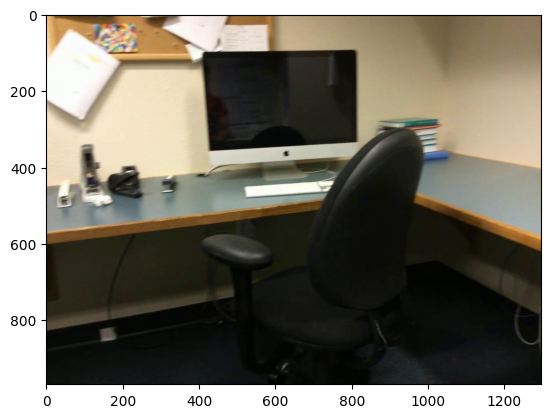

In [6]:
frame_idx = len(frames)-1 # choose the last frame
plt.imshow(frames[frame_idx])

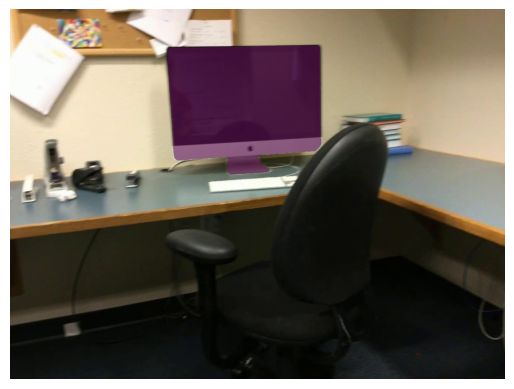

In [7]:
frame_data = frames[frame_idx]
mask1 = get_segmentation_from_box([[[400, 100, 800, 500]]], frame_data)
plt.imshow(np.array(frame_data))
ax = plt.gca()


show_mask(mask1, ax=ax, random_color=True)

plt.axis("off")
plt.show()

In [8]:
masks = [mask1]
masks = torch.from_numpy(np.array(masks))

instruction = f"<video>\nThere are one region in the video: <object0>[<REGION>]. Where is <object0> in relation to you right now?"

mask_ids = [frame_idx]*len(masks) 
output = mm_infer(
    (frames, timestamps),
    processor,
    instruction,
    model=model,
    tokenizer=processor.tokenizer,
    do_sample=False,
    modal='video',
    masks=masks.cuda() if masks is not None else None,
    mask_ids=mask_ids
)
print(output)

<object0> is now situated at the 12 o'clock direction from me.
